# Importação e preparação dos dados

In [1]:
import pandas as pd

df = pd.read_csv('../dados/jurisprudencia_selecionada_enunciados.csv', sep = '|')
df.head()

,COD,NUM_ENUNCIADO,COD_AREA,DESCR_AREA,COD_TEMA,DESCR_TEMA,COD_SUBTEMA,DESCR_SUBTEMA,COD_DOC_TRAMITAVEL_ENUNCIADO,TEXTO_ENUNCIADO,ACORDAO,TIPO_PROCESSO
0,1400,1236,50,Responsabilidade,488,Solidariedade,261,Benefício previdenciário,54995437,Não comprovada a participação do beneficiário ...,Acórdão 297/2016 - PL,Tomada de Contas Especial
1,1700,1534,46,Finanças Públicas,981,Exportação,983,Petróleo,55025587,A operação ficta de exportação de plataformas ...,Acórdão 366/2016 - PL,Solicitação do Congresso Nacional
2,5700,5314,50,Responsabilidade,203,Multa,1021,Dosimetria,55455370,"No âmbito do TCU, a dosimetria da pena tem com...",Acórdão 944/2016 - PL,Acompanhamento
3,284,40,45,Direito Processual,162,Princípio da independência das instâncias,481,Decisão judicial,54773746,O princípio da independência das instâncias pe...,Acórdão 30/2016 - PL,Tomada de Contas Especial
4,298,54,49,Pessoal,141,Sistema S,142,Nepotismo,54773402,É vedado aos dirigentes das entidades do Siste...,Acórdão 55/2016 - PL,Representação


In [2]:
df.shape

(13312, 12)

In [3]:
from sklearn.preprocessing import LabelBinarizer

areas = df.groupby(['DESCR_AREA']).groups.keys()
lbArea = LabelBinarizer()
lbArea.fit([x for x in areas])
y = lbArea.transform(df['DESCR_AREA'])
y.shape

(13312, 10)

In [4]:
from keras.preprocessing.text import Tokenizer
import numpy as np

vocabulario = 20000
limite_texto = 200
dim_vetor = 100

tokenizer = Tokenizer(num_words=vocabulario)
tokenizer.fit_on_texts(df['TEXTO_ENUNCIADO'])

sequences = tokenizer.texts_to_sequences(df['TEXTO_ENUNCIADO'])

word_index = tokenizer.word_index
vocabulario = len(word_index) + 1
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 15387 unique tokens.


In [5]:
from keras.preprocessing.sequence import pad_sequences

x = pad_sequences(sequences, maxlen=limite_texto)

print('Shape of data tensor:', x.shape)

Shape of data tensor: (13312, 200)


In [6]:
x.shape, y.shape

((13312, 200), (13312, 10))

# Treinamento

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, GlobalMaxPooling1D
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 1,568,762
Trainable params: 1,568,762
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

W1130 14:06:41.013028 140325814052672 deprecation.py:323] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1130 14:06:41.123758 140325814052672 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 8s 783us/step - loss: 1.3794 - categorical_accuracy: 0.5181 - val_loss: 1.1044 - val_categorical_accuracy: 0.6211
Epoch 2/20
10649/10649 [==============================] - 1s 136us/step - loss: 0.7036 - categorical_accuracy: 0.7616 - val_loss: 0.7569 - val_categorical_accuracy: 0.7582
Epoch 3/20
10649/10649 [==============================] - 2s 141us/step - loss: 0.4521 - categorical_accuracy: 0.8589 - val_loss: 0.7366 - val_categorical_accuracy: 0.7721
Epoch 4/20
10649/10649 [==============================] - 1s 137us/step - loss: 0.3154 - categorical_accuracy: 0.9049 - val_loss: 0.7089 - val_categorical_accuracy: 0.7942
Epoch 5/20
10649/10649 [==============================] - 1s 136us/step - loss: 0.2195 - categorical_accuracy: 0.9352 - val_loss: 0.7076 - val_categorical_accuracy: 0.8055
Epoch 6/20
10649/10649 [==============================] - 1s 135us/step - loss: 0.1475 - ca

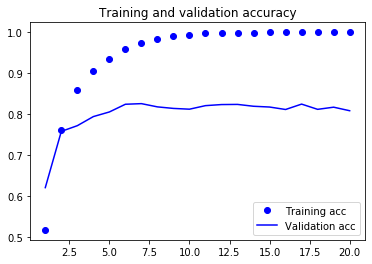

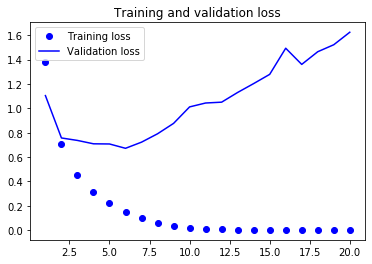

In [13]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
from keras.layers import GRU

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 32, 32)            7200      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 1,575,002
Trainable params: 1,575,002
Non-trainable params: 0
_________________________________________________________________


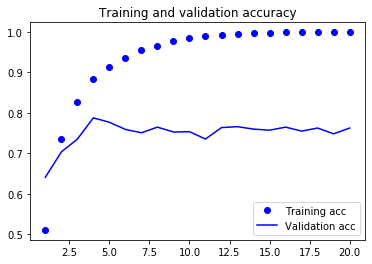

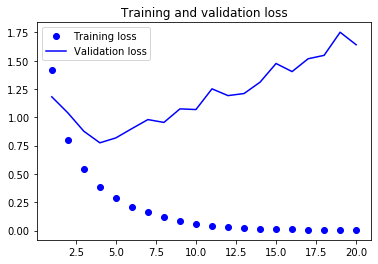

In [16]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=64, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 1,568,762
Trainable params: 1,568,762
Non-trainable params: 0
_________________________________________________________________


In [18]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=128, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 1,568,762
Trainable params: 1,568,762
Non-trainable params: 0
_________________________________________________________________


In [21]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=2e-4),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
Total params: 1,568,762
Trainable params: 1,568,762
Non-trainable params: 0
_________________________________________________________________


10649/10649 [==============================] - 1s 140us/step - loss: 0.0272 - categorical_accuracy: 0.9942 - val_loss: 0.9624 - val_categorical_accuracy: 0.8006
Epoch 42/50
10649/10649 [==============================] - 2s 145us/step - loss: 0.0239 - categorical_accuracy: 0.9957 - val_loss: 0.9517 - val_categorical_accuracy: 0.8092
Epoch 43/50
10649/10649 [==============================] - 2s 154us/step - loss: 0.0210 - categorical_accuracy: 0.9958 - val_loss: 0.9690 - val_categorical_accuracy: 0.8089
Epoch 44/50
10649/10649 [==============================] - 1s 140us/step - loss: 0.0187 - categorical_accuracy: 0.9963 - val_loss: 1.0106 - val_categorical_accuracy: 0.8036
Epoch 45/50
10649/10649 [==============================] - 1s 139us/step - loss: 0.0168 - categorical_accuracy: 0.9969 - val_loss: 0.9831 - val_categorical_accuracy: 0.8175
Epoch 46/50
10649/10649 [==============================] - 1s 141us/step - loss: 0.0148 - categorical_accuracy: 0.9973 - val_loss: 0.9784 - val_cat

In [22]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=5e-4),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 38, 32)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330       
Total params: 1,568,762
Trainable params: 1,568,762
Non-trainable params: 0
_________________________________________________________________


10649/10649 [==============================] - 2s 147us/step - loss: 0.0036 - categorical_accuracy: 0.9996 - val_loss: 1.8608 - val_categorical_accuracy: 0.7938
Epoch 42/50
10649/10649 [==============================] - 2s 144us/step - loss: 0.0038 - categorical_accuracy: 0.9997 - val_loss: 1.8153 - val_categorical_accuracy: 0.7968
Epoch 43/50
10649/10649 [==============================] - 2s 152us/step - loss: 0.0038 - categorical_accuracy: 0.9996 - val_loss: 1.8610 - val_categorical_accuracy: 0.7938
Epoch 44/50
10649/10649 [==============================] - 2s 152us/step - loss: 0.0028 - categorical_accuracy: 0.9996 - val_loss: 1.8358 - val_categorical_accuracy: 0.7968
Epoch 45/50
10649/10649 [==============================] - 2s 150us/step - loss: 0.0023 - categorical_accuracy: 0.9997 - val_loss: 1.8765 - val_categorical_accuracy: 0.7957
Epoch 46/50
10649/10649 [==============================] - 2s 146us/step - loss: 0.0029 - categorical_accuracy: 0.9996 - val_loss: 1.9827 - val_cat

In [25]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=5e-3),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 38, 32)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                330       
Total params: 1,568,762
Trainable params: 1,568,762
Non-trainable params: 0
_________________________________________________________________


In [26]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-2),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 38, 32)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                330       
Total params: 1,568,762
Trainable params: 1,568,762
Non-trainable params: 0
_________________________________________________________________


In [27]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 38, 32)            0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                330       
Total params: 1,568,762
Trainable params: 1,568,762
Non-trainable params: 0
_________________________________________________________________


In [28]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 38, 32)            0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                330       
Total params: 1,568,762
Trainable params: 1,568,762
Non-trainable params: 0
_________________________________________________________________


In [29]:
from keras.layers import GRU

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 38, 32)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_17 (Dense)             (None, 10)                330       
Total params: 1,575,002
Trainable params: 1,575,002
Non-trainable params: 0
_________________________________________________________________


In [31]:
from keras.layers.core import Dropout

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(32, 7, activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 194, 32)           22432     
_________________________________________________________________
dropout_3 (Dropout)          (None, 194, 32)           0         
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 38, 32)            0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32)            0         
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 32)                0         
__________

In [33]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(32, 15, activation='relu'))
model.add(MaxPooling1D(10))
model.add(Conv1D(32, 15, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 186, 32)           48032     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 18, 32)            0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 4, 32)             15392     
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                330       
Total params: 1,602,554
Trainable params: 1,602,554
Non-trainable params: 0
_________________________________________________________________


In [34]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(64, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 194, 64)           44864     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 38, 64)            0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 32, 32)            14368     
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                330       
Total params: 1,598,362
Trainable params: 1,598,362
Non-trainable params: 0
_________________________________________________________________


In [39]:
from keras.layers import Flatten

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 38, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1216)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               311552    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                2570      
Total para